<h1> GAN comparison on Scania Dataset </h1><br>
Development Notebook For generating dataset From Minority Cclass
<hr>

This notebook is adapted from
<a href='https://www.toptal.com/machine-learning/generative-adversarial-networks'>here</a>.<br> and
<a href='https://www.toptal.com/machine-learning/generative-adversarial-networks'>here</a>.<br>
Data is available from IDA 2016 - Industrial Challenges at <a href='https://ida2016.blogs.dsv.su.se/?page_id=1387'>this link.</a><br>


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
# to display fully (non-truncated) data-frame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # revert to 'last_expr' to get only last results

import sys # to make print statements work here

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
random_state = 42

### Check memory

In [ ]:
import psutil
import gc
gc.collect()
psutil.virtual_memory()
print(list(psutil.virtual_memory())[0:2])

4

svmem(total=13609431040, available=12259340288, percent=9.9, used=1032339456, free=7850827776, active=769101824, inactive=4713119744, buffers=436101120, cached=4290162688, shared=1593344, slab=179290112)

[13609431040, 12259340288]


In [ ]:
!pip install

In [ ]:
import xgboost as xgb
import pickle

# Load custom functions
# import GANS#

# For reloading after making changes
import importlib
# importlib.reload(GANS)
# from GANS import *

## Load Dataset

In [1]:
# Load already engineered dataset from EDA section


data_train = pd.read_csv("pca_aps_mean_failure_train_set.csv")
data_test =  pd.read_csv("pca_aps_mean_failure_test_set.csv")


# data columns will be all other columns except class
data_cols = list(data_train.columns[data_train.columns != 'class' ])
label_cols = ['class']


print(data_cols)
print('# of data columns: ',len(data_cols))
print(data_train.shape)
print(data_test.shape)
data_train.head(3)

### Percentage of each class in the dataset
- 0 No failure
- 1 Failure

In [ ]:
# 59000 with no failure (class 0)
# 1000 with failure (class 1)
print("Training:")
data_train['class'].value_counts()
data_train['class'].value_counts()/len(data_train)*100
print("\nTesting:")
data_test['class'].value_counts()
data_test['class'].value_counts()/len(data_test)*100

Training:


,count
class,
0,59000
1,1000


,count
class,
0,98.333333
1,1.666667



Testing:


,count
class,
0,15625
1,375


,count
class,
0,97.65625
1,2.34375


### Put columns in order of importance for xgboost scania (from that section)

In [ ]:
#sorted_cols = xgb_important_features

sorted_cols = data_cols+label_cols
data_train = data_train[sorted_cols ].copy()


### Clustering the failure in Scania dataset - Creating two classes of failures using K-means

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [ ]:
# Add KMeans generated classes to failure data - see classification section for more details on this

import sklearn.cluster as cluster

train = data_train.loc[data_train['class']==1].copy()

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2,
                  'random_state':random_state}

alg = algorithm(*args, **kwds)
labels = alg.fit_predict(train[data_cols])

print(pd.DataFrame([[np.sum(labels==i)] for i in np.unique(labels)],
                    columns=['count'], index=np.unique(labels) ) )

train_failure_w_classes = train.copy()
train_failure_w_classes['class'] = labels

silhouette_score(train[data_cols], labels)

# get silhouette for each cluster
sample_silhouette_values = silhouette_samples(train[data_cols], labels)

cluster_labels = alg.labels_
sil_lbl_dict = {}
for label in range(2):
    sil_lbl_dict[label] =(sample_silhouette_values[cluster_labels == label].mean())

print(sil_lbl_dict)

   count
0    616
1    384


np.float64(0.26594808157273414)

{0: np.float64(0.3536744037932177), 1: np.float64(0.1252204396773753)}


### Exploratory Data Analysis (EDA)

### Total Nulls in dataset (sum over rows, then over columns)

In [ ]:
data_train.isnull().sum().sum()

np.int64(0)

### Check duplications in the dataset for all classes i.e. failure/no failure

In [ ]:
# Duplicates? No

def check_duplicates(df):
    normal_duplicates = sum(df.loc[df['class']==0].duplicated())
    failure_duplicates = sum(df.loc[df['class']==1].duplicated())
    total_duplicates = normal_duplicates + failure_duplicates

    print( 'Normal duplicates', normal_duplicates )
    print( 'Failure duplicates', failure_duplicates )
    print( 'Total duplicates', total_duplicates )
    print( 'Failure duplicated', total_duplicates / len(df))

print("Trainning:")
check_duplicates(data_train)
print("\nTesting")
check_duplicates(data_test)

Trainning:
Normal duplicates 1
Failure duplicates 0
Total duplicates 1
Failure duplicated 1.6666666666666667e-05

Testing
Normal duplicates 0
Failure duplicates 0
Total duplicates 0
Failure duplicated 0.0


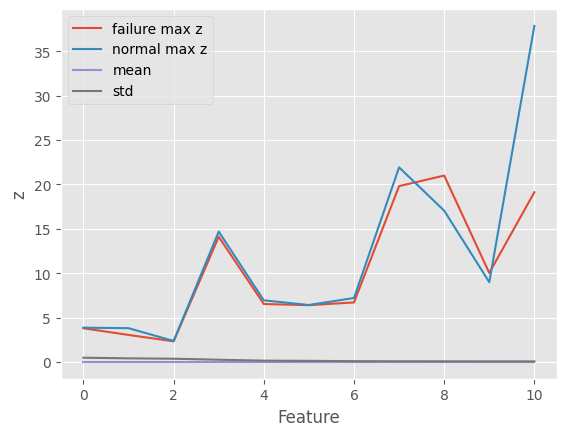

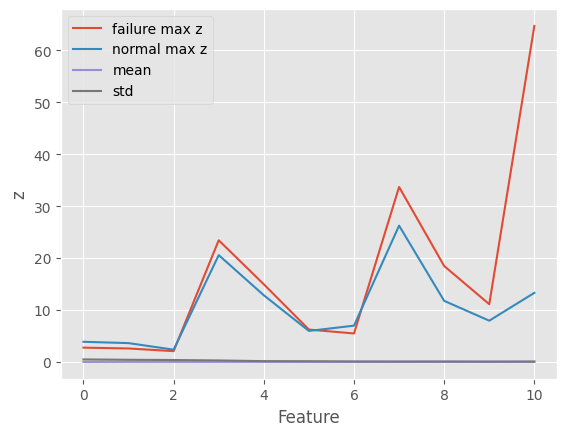

In [ ]:
# There are outliers, 50-100 stdevs away from mean in several columns

def plot_data(df):
    plot_cols = data_cols
    # plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
    # plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
    plt.plot(df.loc[df['class']==1, plot_cols ].abs().max().values / df[plot_cols ].std().values, label='failure max z' )
    plt.plot(df.loc[df['class']==0, plot_cols ].abs().max().values / df[plot_cols ].std().values, label='normal max z' )
    plt.plot(df[ plot_cols ].mean().values, label='mean' )
    # plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
    plt.plot(df[ plot_cols ].std().values, label='std' )
    plt.xlabel('Feature')
    plt.ylabel('z')
    plt.legend()
    plt.show();

plot_data(data_train)
plot_data(data_test)

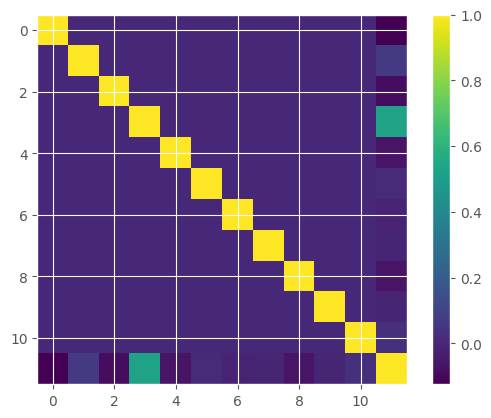

In [ ]:
# Check Correlations
corr0 = data_train.corr()
plt.imshow(corr0)
plt.colorbar();

In [ ]:
# Total nulls in dataset (sum over rows, then over columns)
data_train.isnull().sum().sum()
data_test.isnull().sum().sum()

0

0

<a id="Fig1"><h1>Figure 1: Data Distributions by Feature and Failure/Normal Class</h1></a><br>
<a href='#TOC'>Table of contents</a>

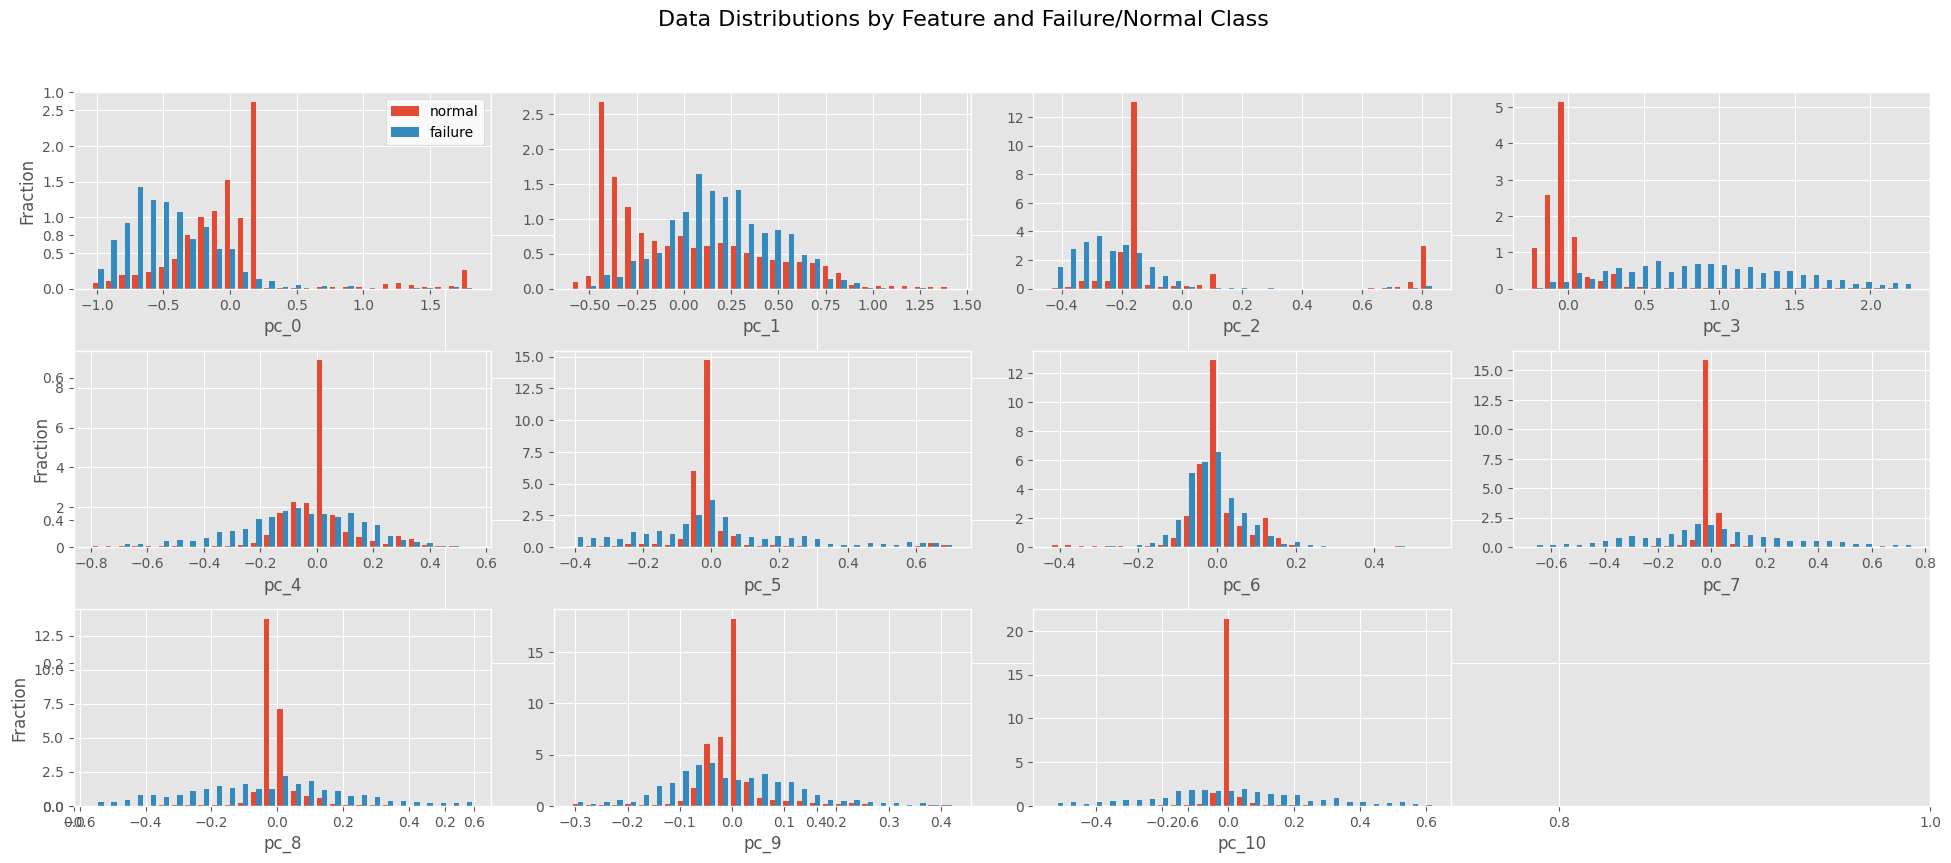

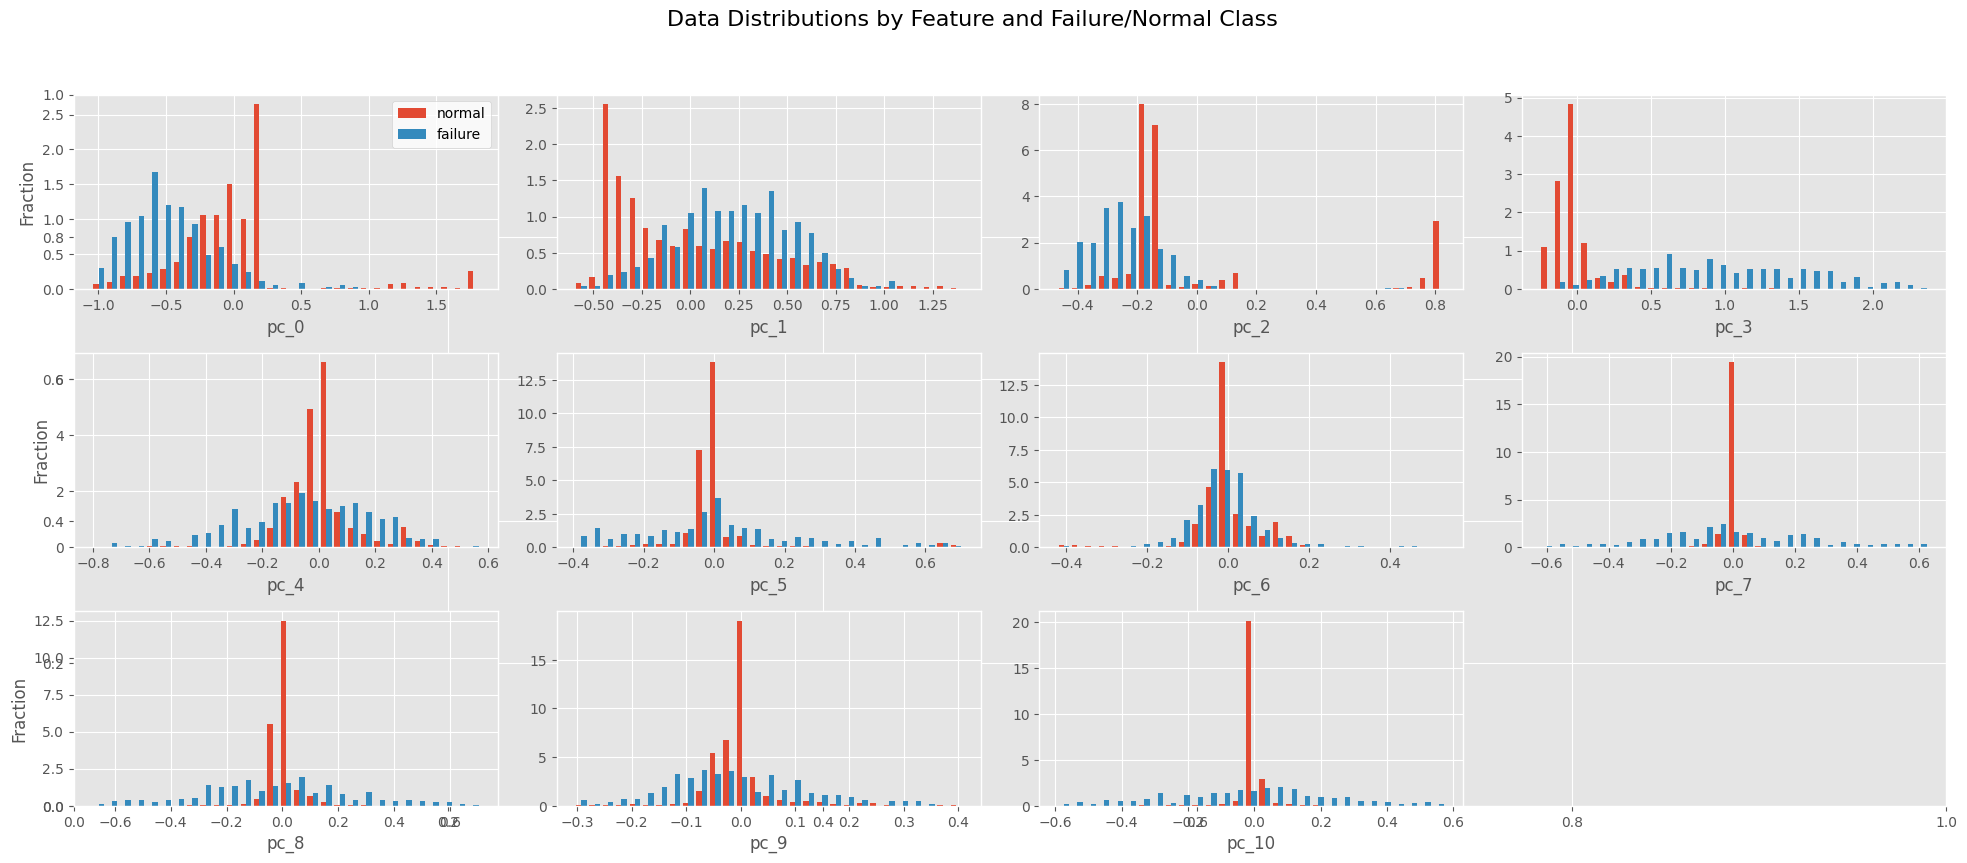

In [ ]:
def plot_data_features(df, fig_name='Scanis_Engineered_Data_Distributions.png'):
    # Plot the data by each feature
    axarr = [[]]*len(data_cols)
    columns = 4
    rows = int(np.ceil(len(data_cols)/columns))
    # f, fig = plt.subplots(figsize=(columns*3.5, rows*2) )
    f, fig = plt.subplots(figsize=(columns*5, rows*3) )

    f.suptitle('Data Distributions by Feature and Failure/Normal Class', size=16)

    for i, col in enumerate(data_cols[:]):
        axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    #     print((int(i//columns), int(i%columns)))
        axarr[i].hist([df.loc[ df['class'] == 0, col ],
                       df.loc[ df['class'] == 1, col ] ],
                       label=['normal','failure'], bins=np.linspace( np.percentile(df[col],0.1),
                                                                    np.percentile(df[col],99.9), 30 ), density=True )
        axarr[i].set_xlabel(col, size=12)
    #     axarr[i].set_ylim([0,0.8])
    #     axarr[i].set_ylim([0,1.5])
        axarr[i].tick_params(axis='both', labelsize=10)
        if i == 0:
            legend = axarr[i].legend()
            legend.get_frame().set_facecolor('white')
        if i%4 != 0 :
            axarr[i].tick_params(axis='y', left='off', labelleft='off')
        else:
            axarr[i].set_ylabel('Fraction',size=12)

    plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
    plt.savefig(fig_name)
    plt.show()
    pass;
plot_data_features(data_train,fig_name='Scanis_Engineered_Train_Distributions.png')
plot_data_features(data_test,fig_name='Scanis_Engineered_Test_Distributions.png')

In [ ]:
# Save engineered dataset as pickle for use in analysis
# pickle.dump(data_train, open('data/' + 'scania.train.engineered.pkl','wb'))
# pickle.dump(data_test, open('data/' + 'scania.test.engineered.pkl','wb'))
# Save as csv for human readability - much slower save
#data.to_csv('data/' + 'scania.engineered.csv.zip')

In [ ]:
# Total nulls in dataset (sum over rows, then over columns)
data_train.isnull().sum().sum()
data_test.isnull().sum().sum()

np.int64(0)

np.int64(0)

### Clustering

In [ ]:
# load clustering libraries

import sklearn.cluster as cluster
#!pip install hdbscan
import hdbscan

from sklearn.metrics import silhouette_score
from collections import Counter, OrderedDict
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import SpectralClustering

from sklearn.cluster import Birch
from sklearn.cluster import MeanShift

from sklearn.mixture import GaussianMixture

In [ ]:

# Set up training set to consist of only fraud data

train = data_train.loc[ data_train['class']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['class']==i)] for i in np.unique(train['class']) ], columns=['count'], index=np.unique(train['class']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]


   count
1   1000


In [ ]:
# Total nulls in dataset (sum over rows, then over columns)
train.isnull().sum().sum()
train_no_label.isnull().sum().sum()

np.int64(0)

np.int64(0)

In [ ]:
%%time

# TSNE is an interesting method to map higher dimensional data into two dimensions
# http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# Note TSNE map may not be what you might think:
# https://distill.pub/2016/misread-tsne/

# Create multiple projections to compare results from different random states

from sklearn.manifold import TSNE

train_no_label = train_no_label.apply(pd.to_numeric)
projections = [ TSNE(random_state=i, n_components=2).fit_transform(train_no_label) for i in range(3) ]
# projections = [ TSNE(random_state=i, n_iter=2000).fit_transform(train_no_label) for i in range(3) ]



CPU times: user 23.4 s, sys: 26.3 ms, total: 23.5 s
Wall time: 23.2 s


In [ ]:
import hdbscan
from sklearn.metrics import silhouette_score
from collections import Counter

spectral clustering 0.379819306387099
Counter({np.int32(0): 908, np.int32(1): 92})
{0: np.float64(0.3909049014273772), 1: np.float64(0.2704093031634834)}
Birch 0.23920610591983074
Counter({np.int64(1): 678, np.int64(0): 322})
{0: np.float64(0.13940692214885197), 1: np.float64(0.2866033583892336)}
Meanshift 0.3855522024310475
Counter({np.int64(0): 989, np.int64(1): 11})
{0: np.float64(0.38505431544421226), 1: np.float64(0.4303167687928662)}
KMeans  0.26594808157273414
Counter({np.int32(1): 616, np.int32(0): 384})
{0: np.float64(0.1252204396773753), 1: np.float64(0.3536744037932177)}
Agglomerative 0.24096500689451136
Counter({np.int64(0): 718, np.int64(1): 282})
{0: np.float64(0.27650101113894976), 1: np.float64(0.1504868116905865)}
Agg. Ave 2 0.36748721937627327
Counter({np.int64(0): 911, np.int64(1): 89})
{0: np.float64(0.37705752622723304), 1: np.float64(0.26952598857600113)}
Agg. Single 2 0.43307024997582416
Counter({np.int64(0): 995, np.int64(1): 5})
{0: np.float64(0.431682801683719

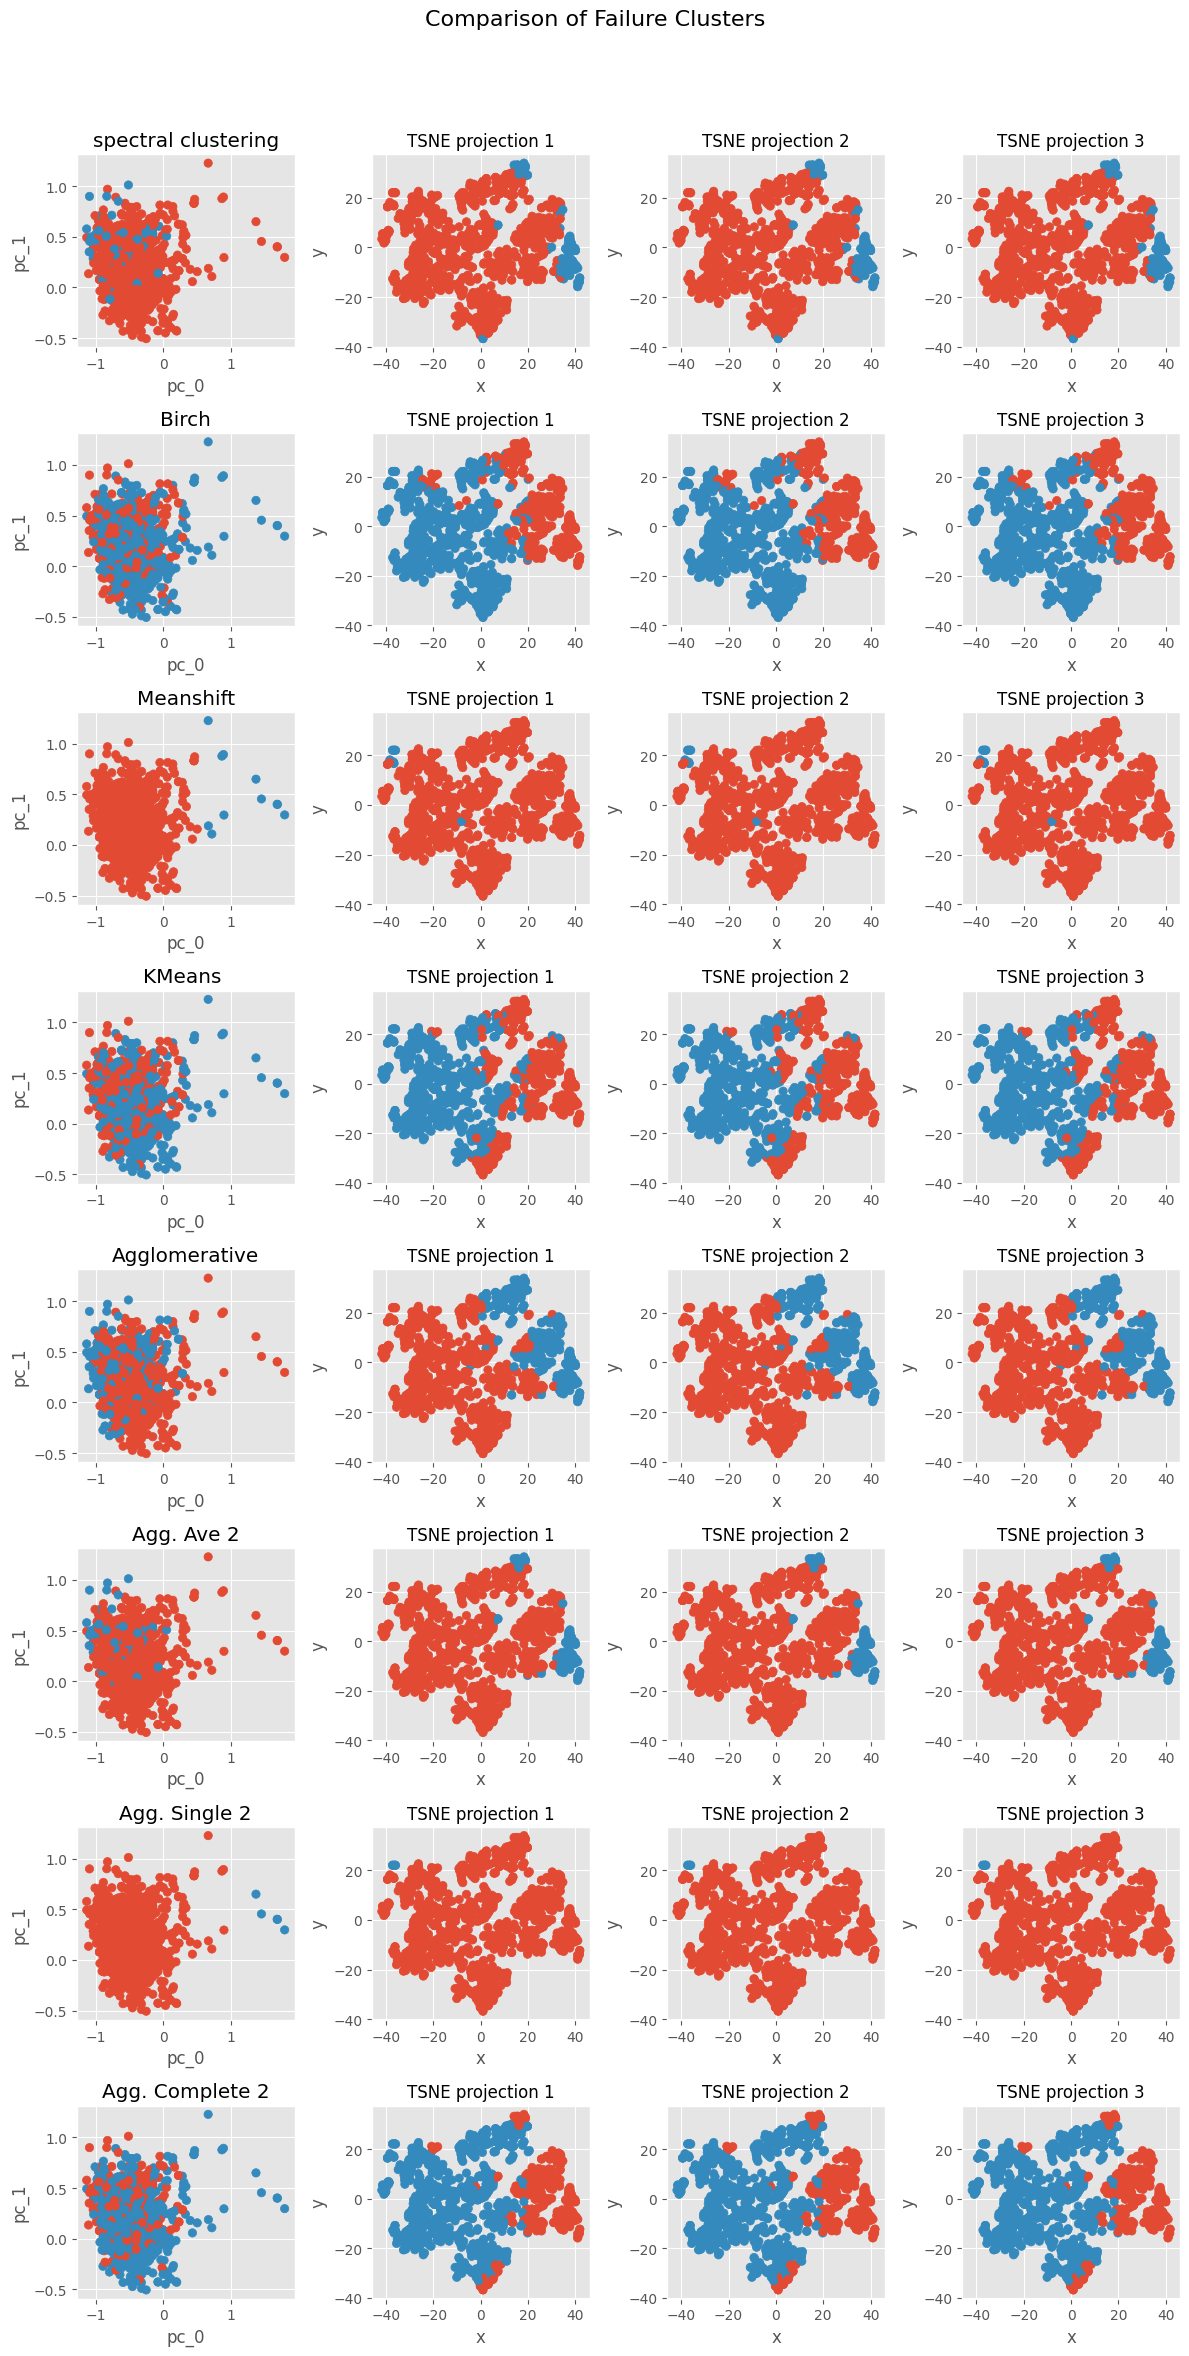

CPU times: user 17.6 s, sys: 158 ms, total: 17.8 s
Wall time: 16.5 s


In [ ]:
%%time


# Now we'll compare some different clustering algorithms
# https://github.com/scikit-learn-contrib/hdbscan/blob/master/docs/comparing_clustering_algorithms.rst

algorithms = [
    ['spectral clustering', SpectralClustering, (), {'n_clusters':2}],
    ['Birch', Birch,(), {'n_clusters':2}],
    ['Meanshift', MeanShift,(), {}],
    ['KMeans ', cluster.KMeans, (), {'n_clusters':2}],
    [ 'Agglomerative', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 2} ],
    [ 'Agg. Ave 2', cluster.AgglomerativeClustering, (), {'linkage': 'average', 'n_clusters': 2} ],
    ['Agg. Single 2', cluster.AgglomerativeClustering, (), {'linkage': 'single', 'n_clusters': 2} ],
    [ 'Agg. Complete 2', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 2} ],

]

rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
#     print(i, name)
    alg = algorithm(*args, **kwds)
    # train_no_label.iloc[:,1:3]
    labels = alg.fit_predict(train_no_label)
    silhouette_avg = silhouette_score(train_no_label, labels)
    print(name, silhouette_avg)
    print(Counter(alg.labels_))

    # get silhouette values for each cluster
    # get silhouette for each cluster
    sample_silhouette_values = silhouette_samples(train_no_label, labels)

    cluster_labels = alg.labels_
    sil_lbl_dict = {}
    for label in range(2):
        sil_lbl_dict[label] =(sample_silhouette_values[cluster_labels == label].mean())

    print(sil_lbl_dict)
    print(''.join(["="]*10))

    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(i) if i>-1 else 'black' for i in colors ]

    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)

    for j in range(3):
        plt.subplot(rows,columns,i*columns+1+j+1)
        plt.scatter(*(projections[j].T), c=colors)
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection '+str(j+1),size=12)
plt.suptitle('Comparison of Failure Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('Failure_Cluster_Diagram.png')
plt.show()

#Agg. Ave 2
#spectral clustering

In [ ]:

# Now pick a set of labels and add to the dataset

#algorithm = cluster.KMeans
algorithm = cluster.AgglomerativeClustering
#args, kwds = (), {'n_clusters':2, 'random_state':random_state}
args, kwds = (),{'linkage': 'average', 'n_clusters': 2}
#args, kwds = (),{'linkage': 'single', 'n_clusters': 2}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)
# labels = algorithm(*args, **kwds).fit_predict(projections[0])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

failure_w_classes = train.copy()
failure_w_classes['class'] = labels

silhouette_score(train_no_label, labels)

# get silhouette for each cluster
sample_silhouette_values = silhouette_samples(train_no_label, labels)

cluster_labels = alg.labels_
sil_lbl_dict = {}
for label in range(2):
    sil_lbl_dict[label] =(sample_silhouette_values[cluster_labels == label].mean())

print(sil_lbl_dict)

   count
0    911
1     89


np.float64(0.36748721937627327)

{0: np.float64(0.2140454108208077), 1: np.float64(0.4307711291194879)}


In [ ]:

# Let's see which features are most useful for detecting differences between the classes:

dtrain = xgb.DMatrix(failure_w_classes[data_cols], failure_w_classes['class'], feature_names=data_cols)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes
    }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for fast evaluation

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print( 'Top eight features: ', [ [i[0],i[1]] for i in sorted_x[:8] ] )


Top eight features:  [['pc_3', 20.0], ['pc_10', 16.0], ['pc_1', 8.0], ['pc_7', 8.0], ['pc_4', 7.0], ['pc_8', 6.0], ['pc_2', 5.0], ['pc_5', 5.0]]


In [ ]:
len(data_cols) # including class

11